# Tutorial

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

## Simple Scenario Example

Import the required modules.

In [ ]:
from uxsim import *
import pandas as pd

### Scenario Definition

First, we will define the main simulation `W`.
The unit of time is s (seconds) and the unit of length is m.

In [ ]:
W = World(
    name="simple_demo",    # Scenario name. Can be blank. Used as the folder name for saving results.
    deltan=5,   # Simulation aggregation unit Δn. Defines how many vehicles are grouped together (i.e., platoon size) for computation. Computation cost is generally inversely proportional to deltan^2.
    tmax=1200,  # Total simulation time (s)
    print_mode=1, save_mode=1, show_mode=1,    # Various options. print_mode determines whether to print information. Usually set to 1, but recommended 0 when running multiple simulations automatically. save_mode determines if visualization results are saved. show_mode determines if visualization results are displayed. It's good to set show_mode=1 on Jupyter Notebook, otherwise recommended 0.
    random_seed=0    # Set the random seed. Specify if you want repeatable experiments. If not, set to None. On Jupyter Notebook, randomness might not always be consistent (requires a fix).
)

The simulation scenario (network structure and demand) is defined.
First, nodes are added, then links are defined to connect the nodes, and finally the traffic demand between the nodes is specified.
In this case, we define a simple Y-shaped merging network.

In [ ]:
W.addNode("orig1", 0, 0) #Create a node. Parameters: node name, visualization x-coordinate, visualization y-coordinate
W.addNode("orig2", 0, 2)
W.addNode("merge", 1, 1)
W.addNode("dest", 2, 1)

W.addLink("link1", "orig1", "merge", length=1000, free_flow_speed=20, jam_density=0.2, merge_priority=0.5) # Create a link. Parameters: link name, start node, end node, length, free_flow_speed, jam_density, merge_priority during merging
W.addLink("link2", "orig2", "merge", length=1000, free_flow_speed=20, jam_density=0.2, merge_priority=2)
W.addLink("link3", "merge", "dest", length=1000, free_flow_speed=20, jam_density=0.2)

W.adddemand("orig1", "dest", 0, 1000, 0.4) # Create OD traffic demand. Parameters: origin node, destination node, start time, end time, demand flow rate
W.adddemand("orig2", "dest", 500, 1000, 0.6)

Instead of defining scenarios by hard-code, scenarios can be read from a CSV file prepared in advance, as shown below.
```python
W.load_scenario_from_csv("dat/siouxfalls_nodes.csv", "dat/siouxfalls_links.csv", "dat/siouxfalls_demand.csv")
```

### Simulation Execution

After defining the scenario, you can execute the simulation with `W.exec_simulation()`. This time, the simulation is run to the end. The simulation time, the number of vehicles in the network at that time, their average speed, and the computation time are displayed.

In [ ]:
W.exec_simulation()

Instead of running the simulation to the end, it is possible to run it halfway and intervene in the simulation.
For example, the following code computes the simulation for 100 seconds at a time and uses the function `hoge` to perform some intervention.

```python
while W.check_simulation_ongoing():
    W.exec_simulation(duration_t=100)
    hoge()
```

### Results

The `W.analyzer` class is responsible for analyzing the results.

A summary of the results can be printed below. Delay ratio is the ratio of delay time to total trip time, with a value close to zero indicating smooth traffic (when the shortest route can be traveled without congestion) and a larger value indicating congestion (when the shortest route is bypassed or congested).

In [ ]:
W.analyzer.network_pillow()

In [ ]:
W.analyzer.print_simple_stats()

Simulation results can be output to pandas.DataFrame. Note that the value `-1` basically means undefined (e.g., headway when there is no vehicle in front).

In [ ]:
#overall
df = W.analyzer.basic_to_pandas()
display(df)

#OD-specific traffic situation
df = W.analyzer.od_to_pandas()
display(df)

#MFD
df = W.analyzer.mfd_to_pandas()
display(df)

#link-level
df = W.analyzer.link_to_pandas()
display(df)

#within link
df = W.analyzer.link_traffic_state_to_pandas()
display(df)

#vehicle-level
df = W.analyzer.vehicles_to_pandas()
display(df)

You can also save the entire results to CSV.

In [ ]:
W.analyzer.output_data()

### Visualization of Results

#### Link-level

Time-space diagrams (density and trajectories) of a link can be plotted as follows.
Ones for consecutive links can also be plotted.

In [ ]:
W.analyzer.time_space_diagram_density()
W.analyzer.time_space_diagram_traj()

W.analyzer.time_space_diagram_traj_links([["link1", "link3"], ["link2", "link3"]])

Cumulative curves, actual/instantanious travel times

In [ ]:
W.analyzer.cumulative_curves()

#### Area/Network-level

MFD

In [ ]:
W.analyzer.macroscopic_fundamental_diagram()

Snapshots of network traffic situation

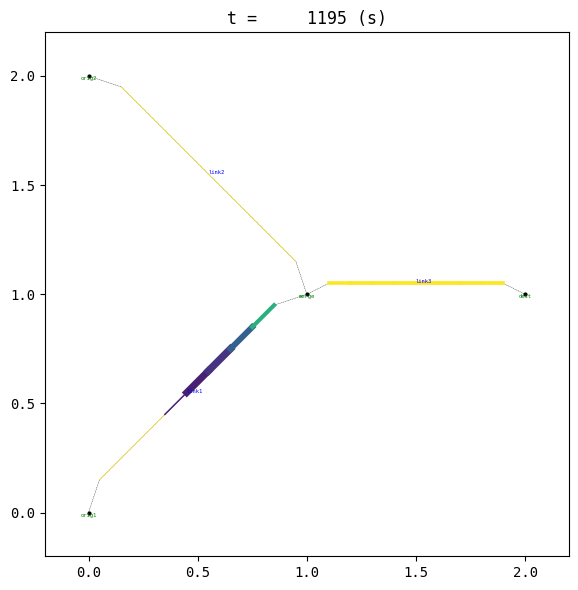

NoneType

In [15]:
W.analyzer.network(W.TIME)

In [ ]:
for t in list(range(0,W.TMAX,int(W.TMAX/6))):
    W.analyzer.network(t, detailed=0, network_font_size=0, figsize=(4,4))
for t in list(range(0,W.TMAX,int(W.TMAX/6))):
    W.analyzer.network(t, detailed=1, network_font_size=0)

You can also create a gif animation of the traffic situation of the entire network.
By default, you can visualize the traffic situation per link, the traffic situation per section within a link (not very clear depending on the network geometry), and the movement trajectory of some vehicles.
The thicker the width of the link, the greater the number and density of vehicles, and the darker the color, the lower the speed.
Note that the creation speed for large scenarios is very slow.

In [ ]:
W.analyzer.network_anim(animation_speed_inverse=15, timestep_skip=30, detailed=0, network_font_size=1)
W.analyzer.network_anim(detailed=1, figsize=(12,12), network_font_size=0)
W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.3, interval=3, trace_length=5, network_font_size=1)

from IPython.display import display, Image
with open("outsimple_demo/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
with open("outsimple_demo/anim_network1.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
with open("outsimple_demo/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
    

#### Vehicle-level

The driving log of a single vehicle can also be visualized. The links traveled and the speed at that time.

In [ ]:
W.analyzer.plot_vehicle_log("100")

## Sioux Falls Network

An example with Sioux Falls network, a famous scenario for benchmarking in transportation research

In [ ]:
# Simulation main
W = World(
    name="simple_demo",
    deltan=5,
    tmax=7200,
    print_mode=1, save_mode=1, show_mode=0,
    random_seed=0
)

# Scenario definition
#load CSV files
W.load_scenario_from_csv("dat/siouxfalls_nodes.csv", "dat/siouxfalls_links.csv", "dat/siouxfalls_demand.csv")

# Simulation execution
W.exec_simulation()

# Results analysis
W.analyzer.print_simple_stats()

W.analyzer.network_anim(animation_speed_inverse=15, timestep_skip=8, detailed=0, network_font_size=0)

In [ ]:
with open("outsimple_demo/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))